In [41]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd

from scipy import stats
# logistic (or inverse-logit) is the inverse of the logit function
from scipy.special import expit as logistic

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from causalgraphicalmodels import CausalGraphicalModel
import daft

This is based on the [homework of week 6](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week06.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
The dataset can be found [here](https://github.com/rmcelreath/rethinking/blob/Experimental/data/)
<br>
<br>
"The data in NWOGrants are outcomes for scientific funding applications for the Netherlands Organization for Scientific Research (NWO) from 2010-2012 (see van der Lee and Ellemers doi:10.1073/pnas.1510159112)."

In [42]:
df = pd.read_csv('../data/NWOGrants.csv', sep=';')

# create categories for gender and discipline as it'll be required
# female = 1
# male = 0
df['gender_id'] = (df['gender']=='f').astype(int)
df['discipline_id'] = df['discipline'].astype('category').cat.codes
df

,discipline,gender,applications,awards,gender_id,discipline_id
0,Chemical sciences,m,83,22,0,0
1,Chemical sciences,f,39,10,1,0
2,Physical sciences,m,135,26,0,5
3,Physical sciences,f,39,9,1,5
4,Physics,m,67,18,0,6
5,Physics,f,9,2,1,6
6,Humanities,m,230,33,0,2
7,Humanities,f,166,32,1,2
8,Technical sciences,m,189,30,0,8
9,Technical sciences,f,62,13,1,8


## Effects of gender on grant awards
Total and indirect causal effects of gender on grant awards.

The Generalized Linear Model (GLM) we will use is the *Aggregated Binomial Regression*. It uses *Binomial Probability* functions. We'll do so because the values a aggregated and the outcome can take the value 0 or any positive integer up to n (the number of trials).
<br>
<br>
The Binomial distribution is used to count events, in a case where  we know the number of trials.
<br>
<br>
Different from the Normal distribution, neither of the 2 parameters of the Binomial distribution represents the mean, therefore, we need a **Link Function**. For the case of the Binomial distribution this link function is the **Logit Link**, it maps the parameter as a probability mass by constraining it to lie between zero and one.

In [43]:
with pm.Model() as m1:
    a = pm.Normal('a', 0, 1.5, shape=len(df.gender_id.unique()))
    p = pm.math.invlogit(a[df.gender_id])
    
    awards = pm.Binomial('awards', n=df.applications, p=p, observed=df.awards)
    m1_trace = pm.sample()
    
    m1_data = az.from_pymc3(m1_trace)
    m1_prior = az.from_pymc3(prior=pm.sample_prior_predictive())
    m1_post_pred = pm.sample_posterior_predictive(m1_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<AxesSubplot:title={'center':'a\n0'}>,
        <AxesSubplot:title={'center':'a\n0'}>],
       [<AxesSubplot:title={'center':'a\n1'}>,
        <AxesSubplot:title={'center':'a\n1'}>]], dtype=object)

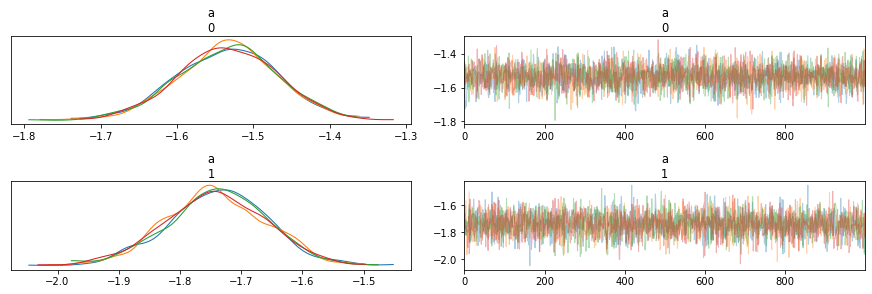

In [44]:
az.plot_trace(m1_trace)

All chains seem healthy as they all look like "hairy caterpillars".

array([[<AxesSubplot:title={'center':'a'}>]], dtype=object)

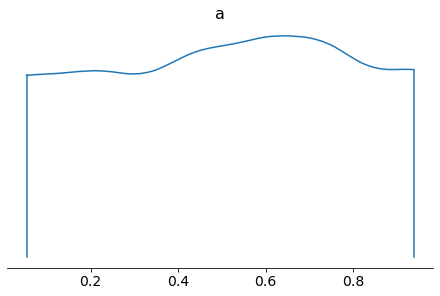

In [45]:
az.plot_density([logistic(m1_prior.prior.sel(a_dim_0=0))],
                var_names=["a"],
                group="prior",
                point_estimate=None,
               )

Observing the prior posterior predictive plot above, we can see it gives each gender a somehow equal probability between 0 and 100% of being more related to awards. 
<br>
<br>
It's important to observe that: "A flat prior in the logit space is not a flat prior in the outcome probability space."
<br>
That's why it's fundamental to plot it and see if it looks reasonable.

In [46]:
az.summary(m1_trace, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a[0],-1.53,0.06,-1.65,-1.41
a[1],-1.74,0.08,-1.90,-1.59


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

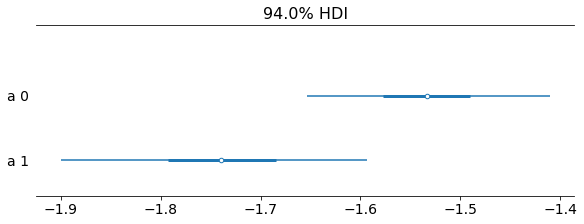

In [47]:
az.plot_forest([m1_trace], 
              var_names=["a"],
              combined=True,
              figsize=(8,3))

By the forest plot above we can see clearly that there's a total direct effect on grant awards is greater if the gender is masculiine **a0**.

In [48]:
m1_diff_a = m1_data.posterior['a'].sel(a_dim_0=0) - m1_data.posterior['a'].sel(a_dim_0=1)
m1_diff_p = logistic(m1_data.posterior['a'].sel(a_dim_0=0)) - logistic(m1_data.posterior['a'].sel(a_dim_0=1))

az.summary({"diff_a": m1_diff_a, "diff_p": m1_diff_p})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
diff_a,0.206,0.106,0.008,0.411,0.002,0.001,3602.0,3317.0,3611.0,3081.0,1.0
diff_p,0.028,0.014,0.002,0.055,0.000,0.000,3623.0,3350.0,3628.0,3106.0,1.0


We are exploring 2 ways of contrasting predictions:
* **diff_a** are the **Absolute Effects**, the difference a counter-factual change in a variable might make on an absolute scale of measurement. "How much difference does the gender make on being awarded a grant?". In our case we can see that there's on average 21% probability of being awarded a grant if you're male.

* **diff_p** are the **Relative Effects** that are the proportional changes in the odds of an outcome. These **Proportional Odds** show that the difference is somewhere between 1.5 and 4.3%.  

In [49]:
df['m1_pred'] = m1_post_pred['awards'].mean(0)

[]

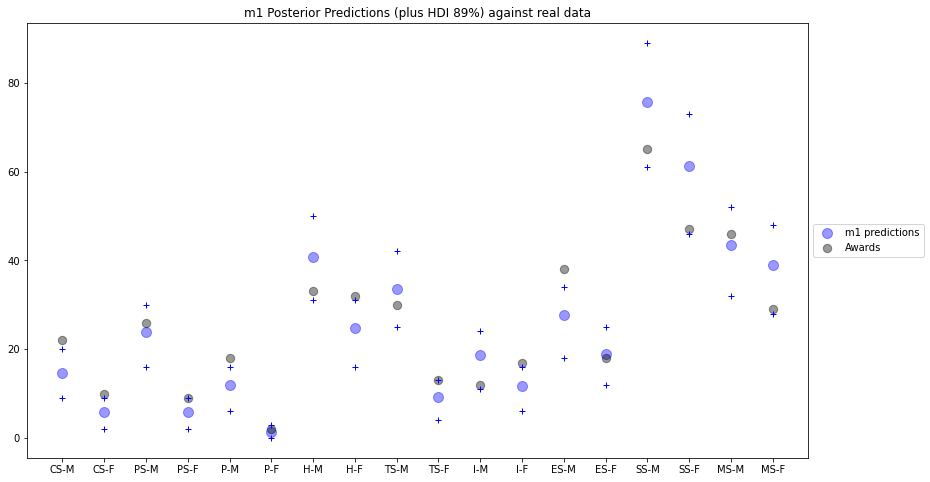

In [50]:
x_axis = np.linspace(0, 17, 18)

_, ax = plt.subplots(figsize=(14,8))
ax.scatter(x_axis, df.m1_pred, c='b', s=100, alpha=0.4, label='m1 predictions')
ax.scatter(x_axis, df.awards, c='k', s=70, alpha=0.4, label='Awards')
ax.plot([range(0,18), range(0,18)], az.hdi(m1_post_pred['awards'], hdi_prob=.89).T, 'b+')

plt.title('m1 Posterior Predictions (plus HDI 89%) against real data')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xticks(x_axis) 
ax.set_xticklabels(('CS-M', 'CS-F', 'PS-M', 'PS-F', 'P-M', 'P-F', 'H-M', 'H-F', 
                    'TS-M', 'TS-F', 'I-M', 'I-F', 'ES-M', 'ES-F', 'SS-M', 'SS-F', 
                    'MS-M', 'MS-F'))
plt.plot()

The plot above is the posterior check of the predictions against the real data. The **High Density Interval** (HDI) of 89% for the predictions, bounded by the "+", is also included. Notice that some of real data falls out of this interval.

Now, for our causal model, let's consider a mediation path (a pipe) through disciplines.

In [51]:
with pm.Model() as m2:
    a = pm.Normal('a', 0, 1.5, shape=len(df.gender_id.unique()))
    b = pm.Normal('b', 0, 1.5, shape=len(df.discipline_id.unique()))
    
    p = pm.math.invlogit(a[df.gender_id] + b[df.discipline_id])
    
    awards = pm.Binomial('awards', n=df.applications, p=p, observed=df.awards) 
    
    m2_trace = pm.sample(2000)
    m2_data = az.from_pymc3(m2_trace)
    m2_post_pred = pm.sample_posterior_predictive(m2_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.71451515520171, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8937240742998186, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


array([[<AxesSubplot:title={'center':'a\n0'}>,
        <AxesSubplot:title={'center':'a\n0'}>],
       [<AxesSubplot:title={'center':'a\n1'}>,
        <AxesSubplot:title={'center':'a\n1'}>],
       [<AxesSubplot:title={'center':'b\n0'}>,
        <AxesSubplot:title={'center':'b\n0'}>],
       [<AxesSubplot:title={'center':'b\n1'}>,
        <AxesSubplot:title={'center':'b\n1'}>],
       [<AxesSubplot:title={'center':'b\n2'}>,
        <AxesSubplot:title={'center':'b\n2'}>],
       [<AxesSubplot:title={'center':'b\n3'}>,
        <AxesSubplot:title={'center':'b\n3'}>],
       [<AxesSubplot:title={'center':'b\n4'}>,
        <AxesSubplot:title={'center':'b\n4'}>],
       [<AxesSubplot:title={'center':'b\n5'}>,
        <AxesSubplot:title={'center':'b\n5'}>],
       [<AxesSubplot:title={'center':'b\n6'}>,
        <AxesSubplot:title={'center':'b\n6'}>],
       [<AxesSubplot:title={'center':'b\n7'}>,
        <AxesSubplot:title={'center':'b\n7'}>],
       [<AxesSubplot:title={'center':'b\n8'}>,
   

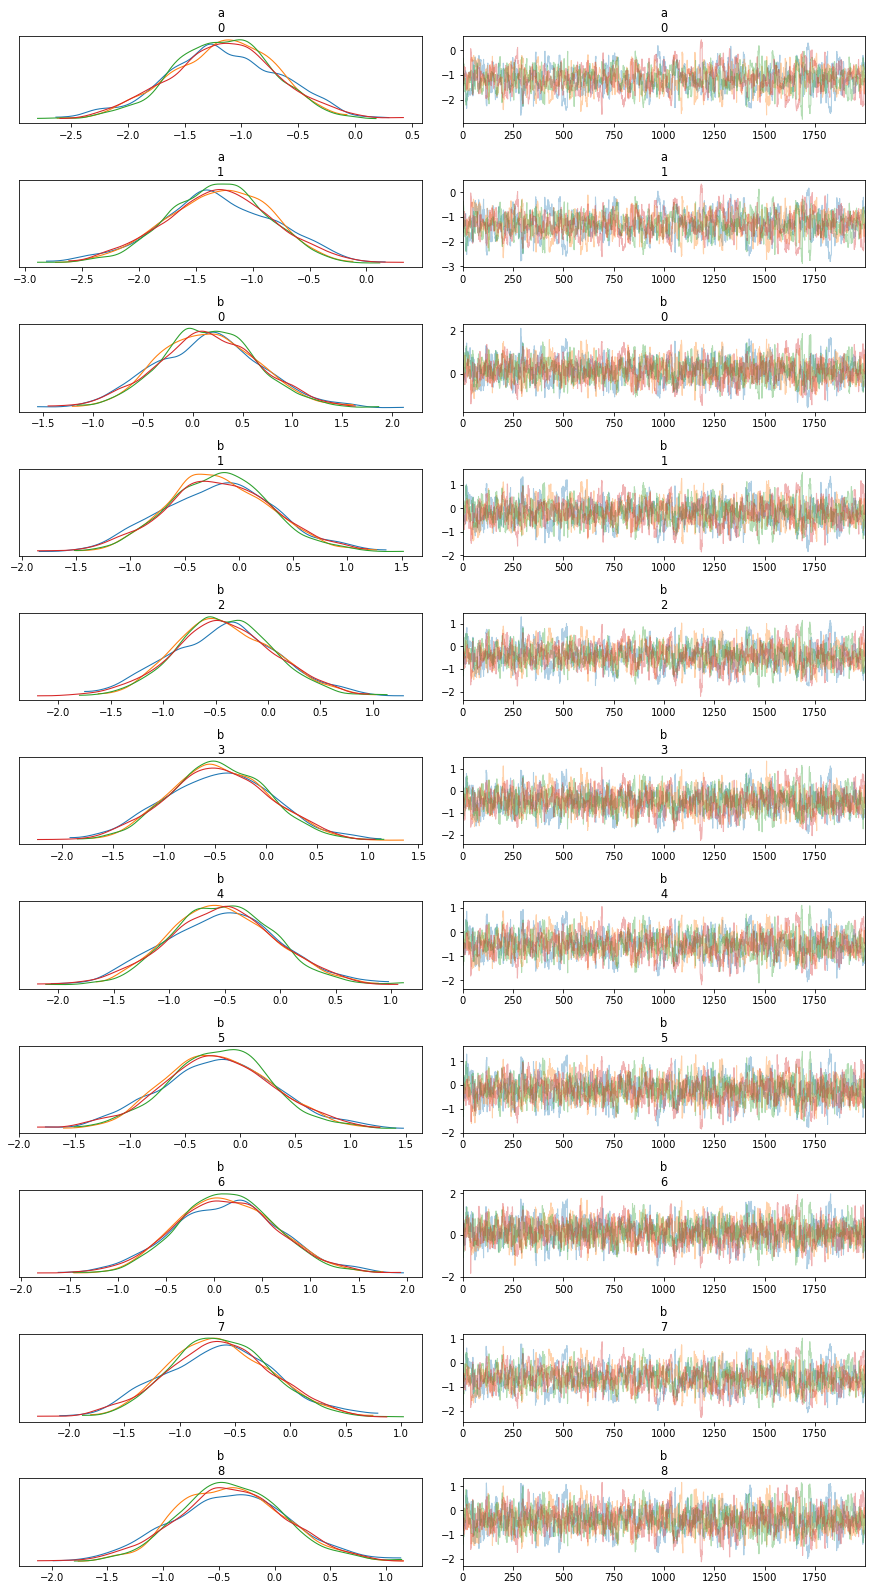

In [52]:
az.plot_trace(m2_trace)

All chains seem healthy as they all look like "hairy caterpillars".
<br>
<br>
The model didn't sample very well probably because it's over-parameterized, one of the parameters **a** is not necessary, but that's ok as this way it makes it easier to assign priors. Besides "it isn't a violation of any statistical principle. The only limitation is whether the algorithm we used to approximate the posterior can handle the high correlations. In this case, it can."

In [53]:
az.summary(m2_trace, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a[0],-1.16,0.47,-2.03,-0.25
a[1],-1.30,0.47,-2.17,-0.38
b[0],0.16,0.50,-0.80,1.08
b[1],-0.18,0.49,-1.11,0.73
b[2],-0.41,0.48,-1.36,0.47
b[3],-0.46,0.50,-1.40,0.47
b[4],-0.52,0.48,-1.44,0.36
b[5],-0.19,0.50,-1.15,0.74
b[6],0.13,0.52,-0.88,1.07
b[7],-0.64,0.48,-1.49,0.31


In [54]:
m2_diff_a = m2_data.posterior['a'].sel(a_dim_0=0) - m2_data.posterior['a'].sel(a_dim_0=1)
m2_diff_p = logistic(m2_data.posterior['a'].sel(a_dim_0=0)) - logistic(m2_data.posterior['a'].sel(a_dim_0=1))

az.summary({"m2_diff_a": m2_diff_a, "m2_diff_p": m2_diff_p})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m2_diff_a,0.139,0.107,-0.075,0.330,0.001,0.001,8318.0,7144.0,8318.0,6928.0,1.0
m2_diff_p,0.024,0.020,-0.014,0.061,0.000,0.000,5258.0,3975.0,5398.0,5156.0,1.0


Text(0.5, 1.0, 'Proportional Odds for m1 and m2')

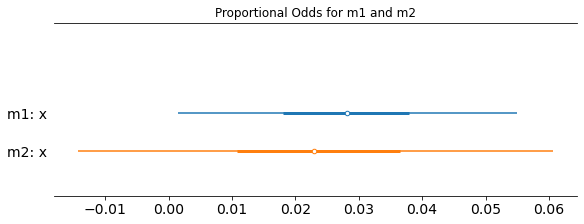

In [55]:
ax = az.plot_forest([m1_diff_p.values, m2_diff_p.values], 
              model_names=['m1', 'm2'], 
              combined=True,
              figsize=(8,3))
ax[0].set_title('Proportional Odds for m1 and m2')

By contrasting models 1 and 2 Proportional Odds we conclude that model 2, that includes the disciplines, slightly decreased the difference of gender, but also increased it's uncertainty, even overlapping 0. 

In [56]:
df['m2_pred'] = m2_post_pred['awards'].mean(0)

[]

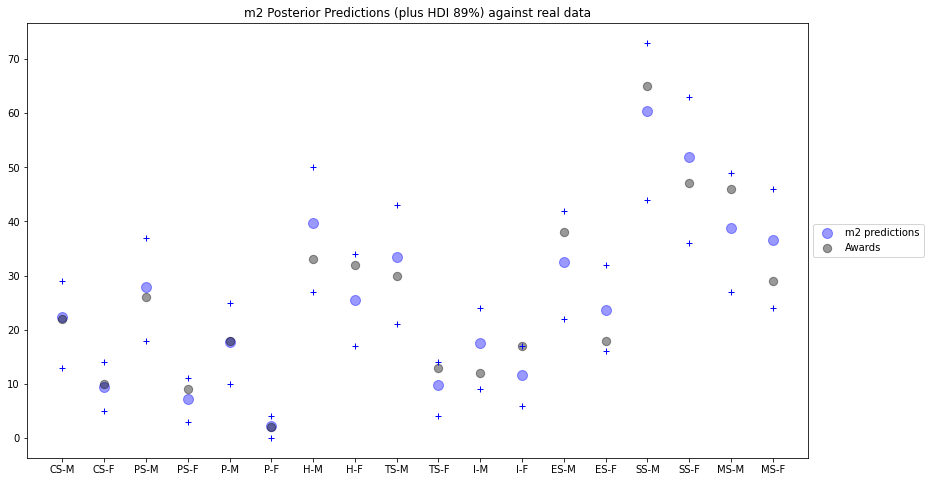

In [57]:
x_axis = np.linspace(0, 17, 18)

_, ax = plt.subplots(figsize=(14,8))
ax.scatter(x_axis, df.m2_pred, c='b', s=100, alpha=0.4, label='m2 predictions')
ax.scatter(x_axis, df.awards, c='k', s=70, alpha=0.4, label='Awards')
ax.plot([range(0,18), range(0,18)], az.hdi(m2_post_pred['awards'], hdi_prob=.89).T, 'b+')

plt.title('m2 Posterior Predictions (plus HDI 89%) against real data')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xticks(x_axis) 
ax.set_xticklabels(('CS-M', 'CS-F', 'PS-M', 'PS-F', 'P-M', 'P-F', 'H-M', 'H-F', 
                    'TS-M', 'TS-F', 'I-M', 'I-F', 'ES-M', 'ES-F', 'SS-M', 'SS-F', 
                    'MS-M', 'MS-F'))
plt.plot()

We have now better predictions for the majority of departments, as compared to the first model the preditions are closer to the real data. Besides, all real data points are within the 89% **High Density Interval** (HDI) of the predictions, represented bounded by the "+".
<br>
<br>
Now it's worth to check the rate of applications across disciplines.

In [58]:
pg = pd.DataFrame(index=['male', 'female'], columns=df.discipline.sort_values().unique())

disc_grp = df.groupby('discipline')

for disc in df.discipline.unique():
    pg[disc] = (disc_grp.get_group(disc)['applications']*100/disc_grp.get_group(disc)['applications'].sum()).round(2).values
    
pg

,Chemical sciences,Earth/life sciences,Humanities,Interdisciplinary,Medical sciences,Physical sciences,Physics,Social sciences,Technical sciences
male,68.03,55.32,58.08,57.38,48.51,77.59,88.16,50.96,75.3
female,31.97,44.68,41.92,42.62,51.49,22.41,11.84,49.04,24.7


We can see that there's a great difference in the number of applications by gender for each discipline. That's why when we add discipline to the model we get a different prediction on the inference about gender.
<br>
The difference between genders quite small, especially for the last model that considers the disciplines. It's somehow balanced the influence of the discipline on being awarded by grants and the number of applicants by gender. 

The expected DAG for the causal model is the one below where G is gender, D is discipline and A is awards. 
<br>
The direct causal path is **G -> A**, however there's a backdoor (indirect path) **G->D->A**. Conditioning on D closes this indirect path.
<br>
We cannot guarantee that there're no observed confounds influencing the model.

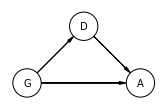

In [59]:
dag_m = CausalGraphicalModel(
    nodes=["A", "G", "D"], edges=[("G", "A"), ("D", "A"), ("G", "D")]
)

pgm = daft.PGM()
coordinates = {"G":(0, 0), "D":(1, 1), "A":(2, 0)}

for node in dag_m.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_m.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

---
---

In [60]:
%load_ext watermark
%watermark -iv -v -nuw

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sat Feb 06 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

matplotlib: 3.3.2
daft      : 0.1.0
seaborn   : 0.11.0
arviz     : 0.10.0
scipy     : 1.5.2
pymc3     : 3.9.3
numpy     : 1.19.2
pandas    : 1.1.3

Watermark: 2.1.0

